# The Drivers of Log Error in Single Unit Zestimates at Zillow
***

# Introduction

### Author
- Samuel Davila
 - Data Scientist
 - Zillow DS Department

### Purpose of project
- Identify what causes the log error values in Zillow property value estimates ("Zestimates") to fluctuate. 
    - For example, are we finding that we do a poor job of estimating the value of properties with a high amount of bathrooms?

### Why is this project important?
- By identifying the drivers of log error, we can find ways to improve our estimates when these drivers are at threshold that would weaken our estimates.
    - For example, if we do a poor job of estimating the values of properties with high amounts of bathrooms, we can study those properties in-depth and refine our methods for evaluating them

### Data source
- Single unit property data from Zillow table in Data Science Database
***

# Executive Summary

### Goals
- Improve original estimate of the log error by using clustering methodologies.
    - Identify drivers of log error
    - Create model that...
    

- Deliver the following:

    - zillow_clustering_project.ipynb

    - README.md

    - acquire.py

    - prep.py

    - prep.py

    - model.py
    
    - A presentation that walks through each step of our project and this notebook as a whole.

### Analysis

Analysis goes here

### Recommendation

Recommendation goes here

### Expectation

Expectation goes here
***

# Project Planning

### Acquire

### Preparation

### Exploraton

### Model

### Conclusion
***

# Acquire
Acquire the data we need for our project from the zillow table in the data science database.

Create __acquire.py__ file that contains the functions needed to replicate this process.
***

#### Importing modules needed for code in notebook to run.

In [1]:
# set up environment
from acquire import get_zillow_data

from prep import drop_missing_columns
from prep import missing_rows
from prep import drop_selected_columns
from prep import drop_more_selected_columns
from prep import compare_column_values
from prep import tax_columns_calculator
from prep import split_data
from prep import add_upper_outlier_columns
from prep import upper_outlier_data_print
from prep import data_scaler
from prep import outlier_remover
from prep import zillow_dummy
from prep import rfe_ranker
from prep import column_renamer
from prep import rfe_column_dropper
from prep import final_prep

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE

import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

#### Using get_zillow_data function (acquire.py)  to import data 

In [2]:
# create variable that will hold DF for easy access to data
df = get_zillow_data()

# previewing data
df.head(2)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,parcelid.1,logerror,transactiondate
0,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,12177905,-0.10341,2017-01-01
1,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,4,10887214,0.00694,2017-01-01


### ACQUIRE TAKEAWAYS
- Acquiring data from zillow database on the data science database server using the __get_zillow_data__ function
- Function needed to replicate this phase is located in the __acquire.py__ file
***

# Prepare
Prepare, tidy, and clean the data for exploration and analysis.

Create __prep.py__ file that contains the functions needed to replicate this process.
***

#### We'll use .info to see null value counts, data types, and row / columns count.

In [3]:
# using info function to examine data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47414 entries, 0 to 47413
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            47414 non-null  int64  
 1   parcelid                      47414 non-null  int64  
 2   airconditioningtypeid         22070 non-null  float64
 3   architecturalstyletypeid      0 non-null      float64
 4   basementsqft                  0 non-null      float64
 5   bathroomcnt                   47414 non-null  float64
 6   bedroomcnt                    47414 non-null  float64
 7   buildingclasstypeid           8 non-null      float64
 8   buildingqualitytypeid         46923 non-null  float64
 9   calculatedbathnbr             47368 non-null  float64
 10  decktypeid                    0 non-null      float64
 11  finishedfloor1squarefeet      0 non-null      float64
 12  calculatedfinishedsquarefeet  47407 non-null  float64
 13  f

- Many columns have a large amount of null values
    - We'll be using a function (missing_rows) to examine the amount of null values in more depth later
    - After examining in-depth, we'll decide how to proceed


- Data type of several columns need to be converted 
    - We'll handle this in a later stage since the columns in question may be removed for in an alternate step 
        - For example, we may remove a column with a bad data type due to it having too many nulls


- Several columns, such as rawcensustractandblock, are categorical variables that may have a very large amount of unique values.
    - Encoding every value for these types of columns may be computationally expensive and add a large amount of columns to our dataset.
        - We will need to set a cutoff amount for categorical column unique values and remove any columns that exceed this amount.


- Once we've identified which columns to move into explore with, we'll need to rename them if they are hard to read, such as landtaxvaluedollarcnt.


#### Using missing_rows function (prep.py) to create DF that shows the total number and percent of missing rows in each column of our data.

In [4]:
# function creates DF displaying number and percent of rows missing from each column
missing_rows(df)

,num_rows_missing,pct_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,25344,53.452567
architecturalstyletypeid,47414,100.000000
basementsqft,47414,100.000000
...,...,...
censustractandblock,116,0.244653
id.1,0,0.000000
parcelid.1,0,0.000000
logerror,0,0.000000


- There are many columns with a substantial amount of missing values
    - We will remove any columns that are missing 40% or more of their values
    - We don't have an exact formula for why we should go with 40% but it seems reasonable to remove any columns that are missing that proportion of values.

#### Using drop_missing_columns function (prep.py) to remove columns that are missing 40% or more of their values.

In [5]:
# function removes any columns that are missing 40% or more of their values
df = drop_missing_columns(df)

# previewing data
df.head(2)

,id,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,id.1,parcelid.1,logerror,transactiondate
0,2288172,12177905,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,...,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,3,12177905,-0.10341,2017-01-01
1,1970746,10887214,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,...,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,4,10887214,0.00694,2017-01-01


#### While examining the data in SQL, we noticed that several columns appeared to have identical values. 

#### Using compare_column_values (prep.py) to find how many unique values exist between the columns in question.

In [6]:
# function prints out sum of unique values between various columns
compare_column_values(df)

Number of different values between finishedsquarefeet12 and calculatedfinishedsquarefeet: 48
Number of different values between calculatedbathnbr and bathroomcnt: 46
Number of different values between fullbathcnt and bathroomcnt: 46


- The sum of non-duplicate values between all of these columns is 140 (48 + 46 + 46). 
    - This is roughly .003 of all rows in the DF
        - We can safely drop all the following majority-duplicate columns and only lose a extremely small proportion of rows.
            - finishedsquarefeet12
            - calculatedbathnbr
            - fullbathcnt
        - We could drop any of their alternativee columns instead but it would cost us time to find a non-arbitrary reason to do so and given how few unique values we're losing, the loss is relatively inconsequential.
        - These columns will be dropped in an upcoming function, __drop_selected_columns__, along with any other columns that are found to be in need of removal.

#### While examining the data in SQL, I noticed that taxvaluedollarcnt appeared to be the sum of landtaxvaluedollarcnt and structuretaxvaluedollarcnt. 

#### To test this I'm going to use tax_columns_calculator (prep.py) to compare the sums of landtaxvaluedollarcnt and structuretaxvaluedollarcnt  to the values in taxvaluedollarcnt.

In [7]:
# function sums landtaxvaluedollarcnt and structuretaxvaluedollarcnt then prints the percent of rows where the sum matched taxvaluedollarcnt
tax_columns_calculator(df)

0.9986501877082719


- 99% of the our summed values matched the original 
    - Safe the say that in a vast majority of rows, taxvaluedollarcnt is the sum of landtaxvaluedollarcnt and structuretaxvaluedollarcnt
        - This being the case, we're only going to keep taxvaluedollarcnt and remove the other two columns since their values are already accounted for in this column.
        - If need be, we can add them back later and see if we get better results by having them seperated.
            - The columns will be dropped at a later step using the __drop_selected_columns__ function

#### We're using nunique() to see how many unique values each column has. This is useful for identifying categorical columns with large amounts of unique values and columns with only a single value.

In [8]:
# nunique() displays each column and the amount of unique values that it holds
df.nunique()

id                              47293
parcelid                        47293
bathroomcnt                        13
bedroomcnt                         12
buildingqualitytypeid              12
calculatedbathnbr                  12
calculatedfinishedsquarefeet     4302
finishedsquarefeet12             4300
fips                                3
fullbathcnt                        12
heatingorsystemtypeid               3
latitude                        38668
longitude                       37041
lotsizesquarefeet               16506
propertycountylandusecode          40
propertylandusetypeid              10
propertyzoningdesc               1854
rawcensustractandblock          25212
regionidcity                      135
regionidcounty                      3
regionidzip                       290
roomcnt                             5
unitcnt                             1
yearbuilt                         131
structuretaxvaluedollarcnt      28782
taxvaluedollarcnt               32671
assessmentye

- The following are categorical columns will be removed because they contain more than 10 unique values. Encoding them would be computationaly expensive and add a large amount of columns to our dataframe.

    - id (both)
    - parcelid (both)
    - buildingqualitytypeid
    - latitude
    - longitude
    - propertylandusetypeid
    - propertycountylandusecode
    - propertyzoningdesc
    - rawcensustractandblock
    - regionidcity
    - regionidzip
    - yearbuilt
    - censustractandblock
    - transactiondate

    
- There are ways to avoid the consequences of encoding categorical columns with lots of features, but in the interest of time we will avoid these routes for now.


- The following columns will be removed because they only contain 1 unique value and would thus not allow us to make any meaningful distinctions with them.

    - assessmentyear
    - unitcnt


- All of these columns will be removed using the __drop_selected_columns__ function from prep.py

#### Dropping columns that meet any of the following criteria (identified in steps prior)
    - Categorical with 10 or more unique values 
    - Only contain 1 unique value
    - landtaxvaluedollarcnt and structuretaxvaluedollarcnt
        - summed under taxvaluedollarcnt column
    - Near-duplicates of alternate column(s)

In [9]:
# function drop columns meeting any criterion above
df = drop_selected_columns(df)

df.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,lotsizesquarefeet,regionidcounty,roomcnt,taxvaluedollarcnt,taxamount,id.1,parcelid.1,logerror
0,3.0,4.0,2376.0,6037.0,2.0,13038.0,3101.0,0.0,145143.0,1777.51,3,12177905,-0.10341
1,3.0,3.0,1312.0,6037.0,2.0,278581.0,3101.0,0.0,119407.0,1533.89,4,10887214,0.00694


#### Using .info to examine our remaining columns

In [10]:
# .info displays information about 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47414 entries, 0 to 47413
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   47414 non-null  float64
 1   bedroomcnt                    47414 non-null  float64
 2   calculatedfinishedsquarefeet  47407 non-null  float64
 3   fips                          47414 non-null  float64
 4   heatingorsystemtypeid         46685 non-null  float64
 5   lotsizesquarefeet             46179 non-null  float64
 6   regionidcounty                47414 non-null  float64
 7   roomcnt                       47414 non-null  float64
 8   taxvaluedollarcnt             47414 non-null  float64
 9   taxamount                     47410 non-null  float64
 10  id.1                          47414 non-null  int64  
 11  parcelid.1                    47414 non-null  int64  
 12  logerror                      47414 non-null  float64
dtypes

- Considering that we'll be encoding our categorical columns, our data types look find for now 
- A few of our columns still have missing values
    - Let's calculate what percent are missing, if the amount is very low, we can drop them instead of imputing them to save time

#### Using our missing_rows (prep.py) function again to find what overall percent of rows are missing values.

In [11]:
# passing dataframe to missing_rows function
missing_rows_df = missing_rows(df)

# summing values in the percent of rows missing column
total_percent_rows_missing = round((missing_rows_df.pct_rows_missing).sum(),0)

print(f'At most, {total_percent_rows_missing}% of rows contain missing values.')

At most, 4.0% of rows contain missing values.


- In the interest of time, we will drop the remaining rows with missing values
    - Given how small this amount is, it should be relatively inconsequential
    - If need be, we can add these rows back in at a later time

#### Dropping rows with missing values

In [12]:
# drop all rows with missing values
df.dropna(inplace = True)

#### RFE PREPARATION CHECKPOINT

At this point, we've removed a significant number of columns and taken care of our missing values.

Our remaining columns will be ranked using Recursive Feature Elimination (RFE) to determine which we will focus on during our initial venture through exploration. 

With that in mind, we'll need to prepare our columns for RFE by
- Encoding categorical columns
- Idenfiying and handling outliers
- Splitting our data into train, validate and test (although we only need train for RFE)
- Scaling the data

#### Before we encode our data, we need to identify our categorical columns so we know which columns to encode

In [13]:
# using nunique to review our data
df.nunique()

bathroomcnt                        13
bedroomcnt                         12
calculatedfinishedsquarefeet     4245
fips                                1
heatingorsystemtypeid               3
lotsizesquarefeet               16337
regionidcounty                      1
roomcnt                             1
taxvaluedollarcnt               31582
taxamount                       44224
id.1                            45470
parcelid.1                      45350
logerror                        45105
dtype: int64

- After dropping all of our null values, we see that fips, regionidcounty and roomcnt have been reduced to one unique value each.
    - We'll remove these columns since they are no longer useful to use with only one unique value
    - If need be, we can return to this stage, impute the missing values that were dropped earlier and retain these columns for exploration

#### Dropping columns with only 1 unique value remaining since all nulls were removed

In [14]:
# using function from prep.py to drop columns with only 1 unique value 
df = drop_more_selected_columns(df)

df.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,heatingorsystemtypeid,lotsizesquarefeet,taxvaluedollarcnt,taxamount,id.1,parcelid.1,logerror
0,3.0,4.0,2376.0,2.0,13038.0,145143.0,1777.51,3,12177905,-0.10341
1,3.0,3.0,1312.0,2.0,278581.0,119407.0,1533.89,4,10887214,0.00694


- With those columns removed we can now encode our sole remaining categorical variable, heatingorsystemtypeid
- All functions for the remainder of our prep phase will come from the __prep.py__ file (not the __prep.py__ file)

### ENCODING

#### Using zillow_dummy function (prep.py) to create dummy variables for heatingorsystemtypeid

In [15]:
# saving resulting df to variable
df = zillow_dummy(df)

# previewing dummy data
df.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,taxamount,id.1,parcelid.1,logerror,heating_system_type_2,heating_system_type_7,heating_system_type_20
0,3.0,4.0,2376.0,13038.0,145143.0,1777.51,3,12177905,-0.10341,1,0,0
1,3.0,3.0,1312.0,278581.0,119407.0,1533.89,4,10887214,0.00694,1,0,0


- Dummy variables added succesfully, now we can split the data


#### Using split_data function (prep.py) to split data into train, validate and test samples.

In [16]:
# function splits data into train, validate and test samples
train, validate, test = split_data(df)

# using shape to see count of rows and columns
train.shape

(25463, 12)

- We use .shape to confirm our number of rows reflects a split and it has

### OUTLIERS

#### We will now use our add_upper_outlier column function (prep.py) to add a column to our dataframe that will reflect how far above the upper boundary a corresponding outlier is, and if the corresponding value is not an outlier, it will contain a 0. 

#### Update: We did not handle lower outliers on our initial venture through the prep phase in order to save time. After seeing the data in visualizations while exploring there did not appear to be any extreme lower outliers so we're not going to invest time in pursuing them.

In [17]:
# function used to identify outliers and their distance from the upper boundary
train = add_upper_outlier_columns(train, k=6)

# previewing data
train.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,taxamount,id.1,parcelid.1,logerror,heating_system_type_2,...,calculatedfinishedsquarefeet_upper_outliers,lotsizesquarefeet_upper_outliers,taxvaluedollarcnt_upper_outliers,taxamount_upper_outliers,id.1_upper_outliers,parcelid.1_upper_outliers,logerror_upper_outliers,heating_system_type_2_upper_outliers,heating_system_type_7_upper_outliers,heating_system_type_20_upper_outliers
44015,3.0,2.0,1150.0,10868.0,168859.0,2122.76,72524,12109437,-0.007175,1,...,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0
40095,3.0,5.0,1895.0,6746.0,428202.0,5519.32,66139,12738882,0.003639,1,...,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0


- Outlier columns added successfully
- Although present, we're disregarding all heating systems outlier columns because they are categorical
- We're also disregarding logerror because we are not removing outliers from our target variable
    - We want our project to reflect the fact that we can't remove outliers in many real-world scenarios
- Set k to 6 which means that only the most extreme outliers will be identified
    - Normally k is set to 1.5 but when we tried this value earlier, we identified so many outliers than removing them all would cost us too much data

#### Now that we have our outlier data, we will use our outlier_data_print function (prep.py) to see on average, how far past the upper boundary each outlier is and how many there are per column.

In [18]:
# function gives a breakdown of outlier data, namely count and average distance from upper boundary
upper_outlier_data_print(train)

~~~
bathroomcnt_upper_outliers
count    7.000000
mean     1.857143
std      1.069045
min      1.000000
25%      1.000000
50%      2.000000
75%      2.000000
max      4.000000
Name: bathroomcnt_upper_outliers, dtype: float64
~~~
bedroomcnt_upper_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_upper_outliers, dtype: float64
~~~
calculatedfinishedsquarefeet_upper_outliers
count       77.000000
mean      2178.129870
std       2793.506024
min         14.000000
25%        468.000000
50%       1111.000000
75%       2877.000000
max      14958.000000
Name: calculatedfinishedsquarefeet_upper_outliers, dtype: float64
~~~
lotsizesquarefeet_upper_outliers
count    2.440000e+03
mean     1.997289e+05
std      2.853832e+05
min      2.400000e+01
25%      4.321000e+04
50%      1.085470e+05
75%      2.504595e+05
max      3.497243e+06
Name: lotsizesquarefeet_upper_outliers, dtype: float64
~~~
taxvaluedollarcnt_upper_outliers

- The "count" and "mean" values above are what we are focused on
     - Count tells us how many upper outliers we have
     - Mean tells us how far above the upper bound (UB) they are on average


- In total, we have 3,192 upper outliers, which is roughly 12% of our dataset
    - This is a fairly signifcant amount but this should be the last data removal step we do before RFE
    - Given that we set k so high earlier (6), these values are extreme outliers so we cannot overlook them


- With all this noted our plan is to remove all outliers as this is the most time saving option we have
    - If we find that we need more data because our model is performing poorly we can revisit this stage and impute the dropped values instead

#### Using outlier_remover function (prep.py) to remove all upper outliers within non-target variable and non-categorical variable columns

In [19]:
# function removes all upper outliers from non-categorical and non-target variable columns
train = outlier_remover(train)

# previewing data 
train.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,taxamount,id.1,parcelid.1,logerror,heating_system_type_2,...,calculatedfinishedsquarefeet_upper_outliers,lotsizesquarefeet_upper_outliers,taxvaluedollarcnt_upper_outliers,taxamount_upper_outliers,id.1_upper_outliers,parcelid.1_upper_outliers,logerror_upper_outliers,heating_system_type_2_upper_outliers,heating_system_type_7_upper_outliers,heating_system_type_20_upper_outliers
44015,3.0,2.0,1150.0,10868.0,168859.0,2122.76,72524,12109437,-0.007175,1,...,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0
40095,3.0,5.0,1895.0,6746.0,428202.0,5519.32,66139,12738882,0.003639,1,...,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0


- all upper outliers dropped from appropriate columns

#### We don't need our outlier columns going forward so we'll drop them to simplify our dataset.

In [20]:
# creating list of outlier column names
outlier_cols = [col for col in train if col.endswith('_outliers')]

# dropping each column from list of outlier columns
train = train.drop(columns = outlier_cols)

# previewing data
train.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,taxamount,id.1,parcelid.1,logerror,heating_system_type_2,heating_system_type_7,heating_system_type_20
44015,3.0,2.0,1150.0,10868.0,168859.0,2122.76,72524,12109437,-0.007175,1,0,0
40095,3.0,5.0,1895.0,6746.0,428202.0,5519.32,66139,12738882,0.003639,1,0,0


- Columns succesfully dropped

### SCALING

#### Using data_scaler (prep.py) to scale the data within our non-categorical and non-target variable columns.

#### We'll be keeping a set of unscaled dataframes for things such as visualizations.

In [21]:
# scaling appropriate numerical columns
train_scaled, validate_scaled, test_scaled = data_scaler(train, validate, test)

# previewing dataframe
train_scaled.head(2)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,taxamount,id.1,parcelid.1,logerror,heating_system_type_2,heating_system_type_7,heating_system_type_20
44015,0.333333,0.181818,0.148556,0.111172,0.064023,0.064408,72524,12109437,-0.007175,1,0,0
40095,0.333333,0.454545,0.259452,0.065931,0.164285,0.174718,66139,12738882,0.003639,1,0,0


- Data scaled successfully
- We're not scaling any of our categorical columns (heatingsystemtypes) 
    - They are all binary values between 0 and 1 and thus don't need scaling
- We're not scaling logerror because its our target variable
- Our data is now ready for Recursive Feature Elimination

### RFE

#### Using rfe_ranker (prep.py) to rank the features in our train dataset via Recursive Feature Elimination.

In [22]:
# Function ranks features using RFE
rfe_ranker(train_scaled)

,Feature,Rank
2,calculatedfinishedsquarefeet,1
4,taxvaluedollarcnt,2
8,heating_system_type_20,3
7,heating_system_type_7,4
6,heating_system_type_2,5
1,bedroomcnt,6
0,bathroomcnt,7
5,taxamount,8
3,lotsizesquarefeet,9


- Recursive Feature Elimination ranks each feature with regard to how strong it is at predicting logerror when used as a feature in a model.


- We're going to move forward with our top 3 features in the exploration phase.
    - 3 features is an adequete number of features to begin working with and if we find that we are in need of more features, we can return to this step and bring in more
    - We're also planning on testing clusters as features in exploration, so this will also help supplement our feature count


- Although the heating_system columns ranked higher than bathroomcnt, it will take more time to work with 3 categorical columns than 1 non-categorical during visualization and hypothesis testing
    - For this reason we will instead take, the next highest ranked feature, bathroomcnt
    
    
- Thus the 3 features we are moving forward with are:
    - calculatedfinishedsquarefeet
    - taxvaluedollarcount
    - bathroomcnt

#### Now that we've identified our top 3 features, we're going to remove the others from our datasets

In [23]:
# function returns our dataframes with only the three we selected after RFE was performed
train, validate, test, train_scaled, validate_scaled, test_scaled = rfe_column_dropper(train, validate, test, train_scaled, validate_scaled, test_scaled)

# previewing data 
train_scaled.head(2)

,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,logerror
44015,0.333333,0.148556,0.064023,-0.007175
40095,0.333333,0.259452,0.164285,0.003639


#### Now we'll rename our columns using our column_renamer function (prep.py) to finish our data prep. 

In [24]:
# function renames various columns for readability
column_renamer(train, validate, test, train_scaled, validate_scaled, test_scaled)

# previewing data 
train_scaled.head(2)

,bathroom_count,property_sq_ft,tax_dollar_value,log_error
44015,0.333333,0.148556,0.064023,-0.007175
40095,0.333333,0.259452,0.164285,0.003639


- Best features have been kept
- Column renaming was successful

#### Let's take one last look at our data to make sure everything is sound.

In [25]:
# using .info to check various properties of our data
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22673 entries, 44015 to 11943
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bathroom_count    22673 non-null  float64
 1   property_sq_ft    22673 non-null  float64
 2   tax_dollar_value  22673 non-null  float64
 3   log_error         22673 non-null  float64
dtypes: float64(4)
memory usage: 885.7 KB


- No missing values
- Data types are correct 
    - scaling values from 0 - 1 produces floats
    - heating system columns are encoded as binary
    - log error is still a float
- Our prep is complete

### PREPARE TAKEAWAYS
- Dropped all columns that met any of the following criterion
    - 40% or more of their values missing
    - Duplicate or near-duplicate of other column(s)
    - Categorical with 10 or more unique values
    - Only contain 1 unique value
    - landtaxvaluedollarcnt and structuretaxvaluedollarcnt
        - Summed under taxvaluedollarcnt column
    - Was not found to be a top feature after RFE was run


- Dropped all rows with missing values


- Removed all extreme outliers from dataset 


- Encoded heating_system column into 3 columns and dropped original


- Scaled all numeric non-categorical, non-target variables


- Data types are valid


- Split data into train, validate and test sets


- Remaining (renamed) features are:
    - bathroom_count	
    - property_sq_ft	
    - tax_dollar_value	


- Our target variable, was renamed log_error


- All custom functions in this phase can be found in the __prepare.py__ and __prep.py__ files
    - When each function is appears in the notebook, the file it's located in is displayed next to it's name in ()
    - To retrieve the data fully prepared, you can alternatively run the __final_prep()__ function (no arguments needed) from the __prep.py__ file
***

# Explore
We will now explore our prepped data to identify drivers of logerror and relationships between variables.

We will be using clustering to aid us in some parts of our exploration.
***

## Non-Clustered Exploration

Let's begin our exploration by creating using visualizations and hypothesis tests to gauge the relationships between our features and our target variable. 
***

### FEATURE: PROPERTY_SQ_FT
Let's explore how the square feet of a property, relates to log error. 

### Visualization - Property_Sq_Ft
#### We'll begin by plotting the relationship between log_error and property_sq_ft

(-4, 4)

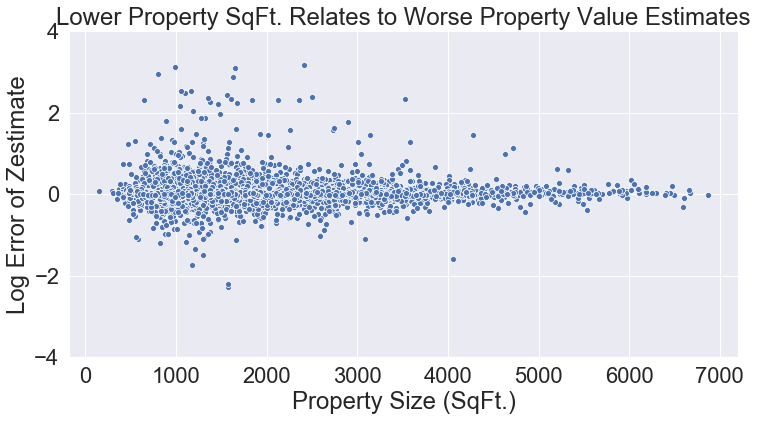

In [26]:
# setting figure size for plot
sns.set(rc = {'figure.figsize':(12,6)})

# adjusting size of text on plot
sns.set(font_scale = 2)

# creating scatter plot and setting title
sns.scatterplot(x = 'property_sq_ft', y = 'log_error', data = train).set_title("Lower Property SqFt. Relates to Worse Property Value Estimates")

# setting x and y labels
plt.xlabel("Property Size (SqFt.)")
plt.ylabel("Log Error of Zestimate")

# setting y limits to ensure they are equal
plt.ylim(-4, 4)

- The farther away from 0 a zestimate's log error is, the farther off from reality the zestimate was


- Generally, the smaller properties have log error values farther from 0 than larger properties 
    - Smaller properties have many more extreme overestimates than larger properties
        - We'll perform a hypothesis test based on this observation
        
        
- Since there appear to be more overestimates than underestimates, we're going to focus on those first

### Hypothesis Test - Property_Sq_Ft

#### We'll now perform a one tailed, two sample t-test to see if smaller properties have higher log error values than larger properties.

- H0 = Log error of properties with below avg. SqFt. __<=__ Log error of properties with avg. or above avg. property SqFt.
- Ha = Log error of properties with below avg. SqFt. __>__ Log error of properties with avg. or above avg. property SqFt.

In [27]:
# finding avg property Sqft.
avg_property_sq_ft = train.property_sq_ft.mean()

# x1 = df of properties with property_sq_ft less than the avg.
# x2 = df of properties with property_sq_ft greater than or equal to the avg.
x1 = train[train.property_sq_ft < avg_property_sq_ft].log_error
x2 = train[train.property_sq_ft >= avg_property_sq_ft].log_error

# performing one tailed, 2 sample t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print(f't = {t:.5f}')
print (f'p = {p / 2}')

alpha = .05

t = -2.34049
p = 0.009633618331998254


- p is below our alpha (.05)
- t is negative
    - p is below alpha but our t value is negative and it needed to be positive for us to reject our null hypothesis in this test.


- However, I'm not convinced there is no connection between property_sq_ft and log error since our plot depicts log error values centering towards 0 as sqft. increases
    - Let's test to see if smaller property sqft. is connected to lower log error values
    - Log errors below 0 are unwanted as they indicate we are undervaluing properties

### Hypothesis Test - Property_Sq_Ft

#### To continue, we'll perform a one tailed, two sample t-test to see if smaller properties relate to lower log error values than larger properties.

- H0 = Log error of properties with below avg. SqFt. __<=__ Log error of properties with avg. or above avg. property SqFt.
- Ha = Log error of properties with below avg. SqFt. __<__ Log error of properties with avg. or above avg. property SqFt.

#### Note: Although the coding for this test is identical to the test prior, I feel it's important that we document it separately with a new hypothesis. 

In [28]:
# finding avg property Sqft.
avg_property_sq_ft = train.property_sq_ft.mean()

# x1 = df of properties with property_sq_ft less than the avg.
# x2 = df of properties with property_sq_ft greater than or equal to the avg.
x1 = train[train.property_sq_ft < avg_property_sq_ft].log_error
x2 = train[train.property_sq_ft >= avg_property_sq_ft].log_error

# performing one tailed, 2 sample t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print(f't = {t:.5f}')
print (f'p = {p / 2}')

alpha = .05

t = -2.34049
p = 0.009633618331998254


- p is below alpha
- t is negative
    - We reject our null hypothesis and conclude there is evidence that properties with less than avg. square feet have lower log error values than properties with avg. or above avg. square feet


- In light of this, we'll keep this feature as a candidate for modeling

### FEATURE: TAX_DOLLAR VALUE
Let's now explore how tax dollar value, relates to log error. 

### Visualization - Tax_Dollar_Value
#### We will plot the relationship between log_error and tax_dollar_value

Text(0, 0.5, 'Log Error of Zestimate')

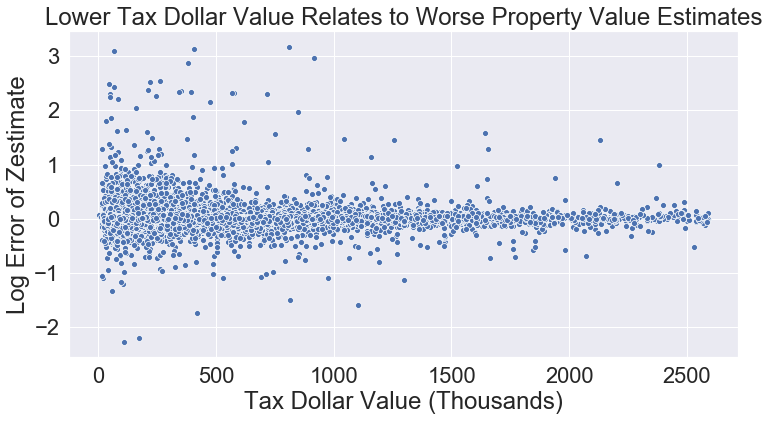

In [29]:
# setting figure size and text size
sns.set(rc = {'figure.figsize':(12,6)})
sns.set(font_scale = 2)

# plotting data, setting title and scaling x axis values to simplify them
sns.scatterplot(x = train['tax_dollar_value'] / 1000, y = 'log_error', data = train).set_title("Lower Tax Dollar Value Relates to Worse Property Value Estimates")
plt.xlabel("Tax Dollar Value (Thousands)")
plt.ylabel("Log Error of Zestimate")

- This visual looks very similar to our previous one and has similar takeaways


- The farther away from 0 a zestimate's log error is, the farther off from reality the zestimate was


- The lower value properties more overestimates and underestimates than larger properties
    - Since lower value properties overestimates are more numerous than their underestimates, we're going to focus on those
       
       
- We'll perform a hypothesis test to see if lower value properties tend to have higher log error values

### Hypothesis Test - Tax_Dollar_Value

#### Let's perform a one tailed, two sample t-test to see if properties with lower tax dollar value relate to higher log error values than higher tax dollar value properties.

- H0 = Log error of properties with below avg. tax_dollar_value __<=__ Log error of properties with avg. or above avg. tax_dollar_value .
- Ha = Log error of properties with below avg. tax_dollar_value __>__ Log error of properties with avg. or above avg. tax_dollar_value 

In [30]:
# finding avg tax dollar value
avg_tax_dollar_value = train.tax_dollar_value.mean()

# x1 = df of properties with tax dollar value less than the avg.
# x2 = df of properties with tax dollar value greater than or equal to the avg.
x1 = train[train.tax_dollar_value < avg_tax_dollar_value].log_error
x2 = train[train.tax_dollar_value >= avg_tax_dollar_value].log_error

# performing one tailed, 2 sample t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print(f't = {t:.5f}')
print (f'p = {p / 2}')

alpha = .05

t = 3.18858
p = 0.0007158276410207939


- p is below our alpha (.05)
- t is positive
    - We reject our null hypothesis and conclude there is evidence that properties with lower sqft. have higher log errors
       
       
- Based on these observations, tax_dollar_value will remain a prospective feature for modeling

### FEATURE: BATHROOM_COUNT
Let's now explore how the number of bathrooms in a property relates to log error. 

### Visualization - Bathroom_Count
#### We will plot the relationship between log_error and tax_dollar_value

Text(0, 0.5, 'Log Error of Zestimate')

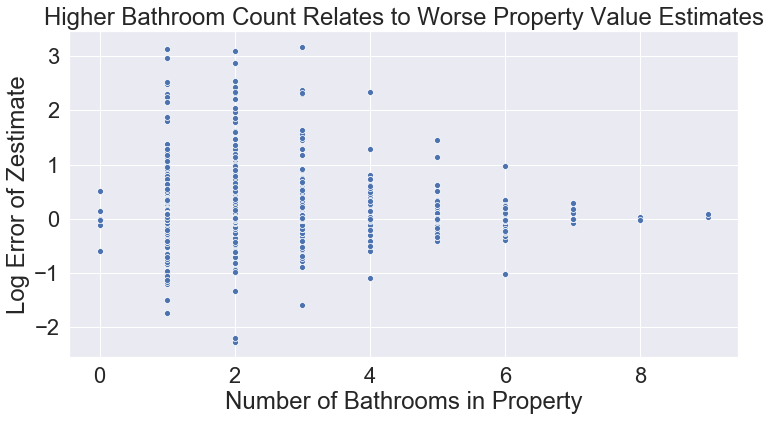

In [31]:
# setting figure size
sns.set(rc = {'figure.figsize':(12,6)})

# setting font size
sns.set(font_scale = 2)

# plotting scatterplot and setting title
sns.scatterplot(x = 'bathroom_count', y = 'log_error', data = train).set_title("Higher Bathroom Count Relates to Worse Property Value Estimates")

# setting x and y label
plt.xlabel("Number of Bathrooms in Property")
plt.ylabel("Log Error of Zestimate")

- Similar to our other features, the graph shows that as the number of bathrooms increases, the range of the log error values gets smaller
    - In other words, it appears that the less bathrooms a property has, the worse our zestimate tends to be
        - Interestingly, this does not appear to be true for properties with no bathrooms
            - If a property has no bathrooms, it may be a special kind of property that we are able to evaluate more effectively
            
- It's difficult to tell wether there are extreme log error values below or above 0
    - We'll perform a hypothesis test for lower log errors since most of our tests have been features having high positive log error values

### Hypothesis Test - Bathroom_Count

#### Let's perform a one tailed, two sample t-test to see if properties with less bathrooms relate to higher log error values than properties with more bathrooms.

- H0 = Log error of properties with below avg. bathroom_count __<=__ Log error of properties with avg. or above avg. bathroom_count
- H0 = Log error of properties with below avg. bathroom_count __<__ Log error of properties with avg. or above avg. bathroom_count

In [32]:
# finding avg bathroom_count
avg_bathroom_count = train.bathroom_count.mean()

# x1 = df of properties with bathroom_count less than the avg.
# x2 = df of properties with bathroom_countgreater than or equal to the avg.
x1 = train[train.bathroom_count < avg_bathroom_count].log_error
x2 = train[train.bathroom_count >= avg_bathroom_count].log_error

# performing one tailed, 2 sample t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print(f't = {t:.5f}')
print (f'p = {p / 2}')

alpha = .05

t = -1.91670
p = 0.027644489299379117


- p is below our alpha (.05)
- t is negative
    - We reject our null hypothesis and conclude there is evidence that properties with lower bathroom counts have lower log errors



- Based on our findings, bathroom_count should be considered a lucrative feature for modeling

## Clustered Exploration

Let's continue exploring by creating clusters that we can create hypothesis tests and visualizations with in order to gain further insight into the drivers of log_error.

Since we're only working with 3 features, we can afford to create a cluster of every unique pair.

It's important to cluster on scaled data when possible so we'll be using our scaled dataset here.

### CLUSTER FEATURE SET 1 - Property_Sq_Ft | Tax_Dollar_Value

Let's cluster using these two features and check if there is any difference between their log error values.

To begin, well use subplots to see what are clusters look like with different cluster amounts. This gives us a good idea of how many clusters we should choose for a given pair.

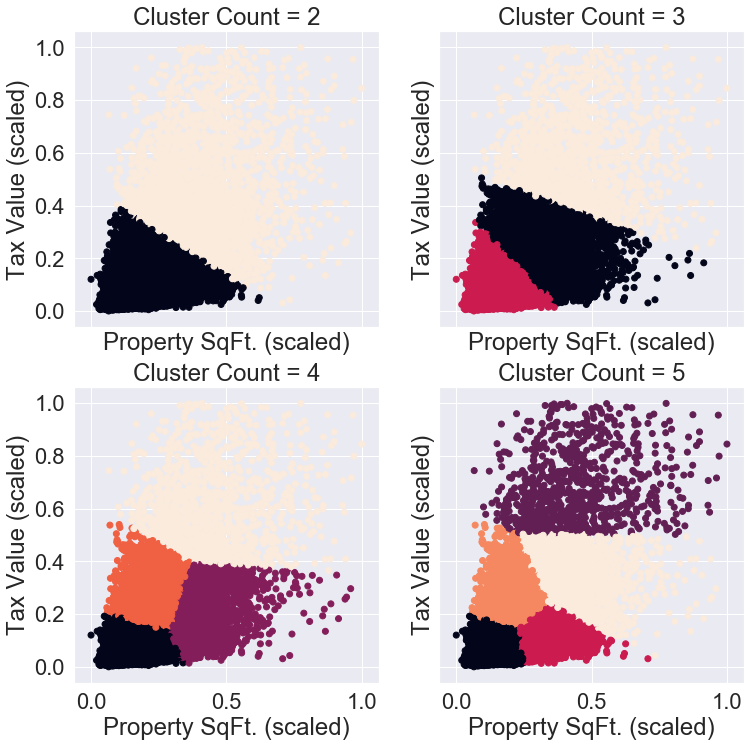

In [33]:
# creating df with the two features we want to cluster
X_c1 = train_scaled[['property_sq_ft', 'tax_dollar_value']]

# setting up subplots
fig, axs = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True)

# creating clusters, number of clusters increasing from 2 - 5
for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_c1).predict(X_c1)
    
    # plotting 
    sns.set(font_scale = 2)
    ax.scatter(X_c1.property_sq_ft, X_c1.tax_dollar_value, c=clusters)
    ax.set(title='Cluster Count = {}'.format(k), xlabel='Property SqFt. (scaled)', ylabel='Tax Value (scaled)')

- We're looking for clean separation between clusters
    - All of them have relatively clean separation between eachother so this is a difficult choice
    - We'll go with 3 clusters to keep things simpler while also having a larger variety of clusters to work with than the minimum

#### Now we'll create our 3 cluster types and add them to our dataframe

In [34]:
# making copy of train so we don't alter the original
train_k1 = train_scaled.copy()

# creating kmeans object and fitting to data
kmeans_1 = KMeans(n_clusters=3)
kmeans_1.fit(X_c1)

# creating clusters and adding as column
train_k1['cluster'] = kmeans_1.predict(X_c1)

#### Now we're going to examine our clusters in-depth and identify what they each represent.

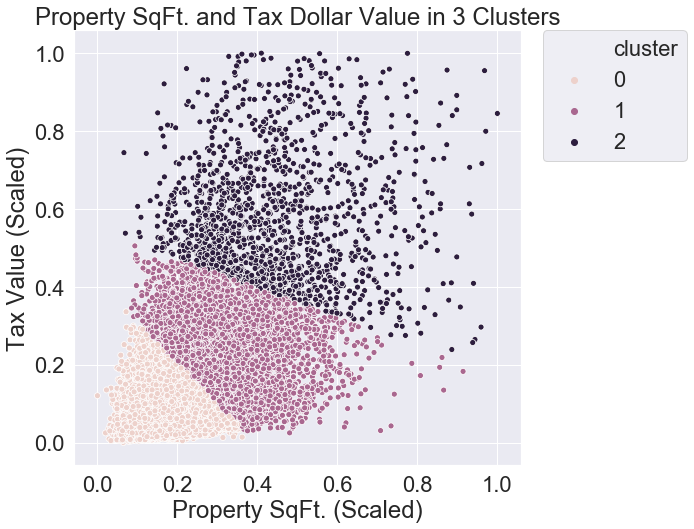

In [35]:
# setting figure and text size 
sns.set(rc = {'figure.figsize':(8,8)})
sns.set(font_scale = 2)

# plotting data, setting title and scaling y axis values to simplify them
sns.scatterplot(x = train_k1['property_sq_ft'], y = train_k1['tax_dollar_value'], data = train_k1, hue = 'cluster').set_title("Property SqFt. and Tax Dollar Value in 3 Clusters")
plt.xlabel("Property SqFt. (Scaled)")
plt.ylabel("Tax Value (Scaled)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Cluster 0 is mostly 
    - low value
    - small-size properties


- Cluster 1 is mostly 
    - low-to-mid value 
    - small-to-medium size properties 

       
- Cluster 2 is mostly 
    - mid-to-high value 
    - small-to-medium size properties

## Cluster Feature Set 1 - Hypothesis Test - ANOVA

Now that we've identified the characterstics of our properties, we'll perform an anova test to see if there is any difference in their average log errors.

- H0 = There is no difference between the average log error of cluster 0, cluster 1, and cluster 2
- Ha = There is a difference between the average log error of cluster 0, cluster 1, and cluster 2

In [36]:
# creating an array for the log error of each cluster type
cluster_0 = train_k1[train_k1.cluster == 0].log_error
cluster_1 = train_k1[train_k1.cluster == 1].log_error
cluster_2 = train_k1[train_k1.cluster == 2].log_error

# performing ANOVA test
f, p = stats.f_oneway(cluster_0, cluster_1, cluster_2)

# printing results
print(f'alpha = .05\n')
print(f'f = {f:.5f}')
print (f'p = {p}')

alpha = .05

f = 0.28022
p = 0.7556166600472636


- p is much greater than alpha
- We fail to reject our null hypothesis and conclude there is no difference in log error between the clusters
- In light of this, we will not be using this cluster for further analysis

### CLUSTER Feature Set 2 - Property_Sq_Ft | Bathroom_Count

Let's cluster using these two features and check if there is any difference between their log error values.

To begin, well use subplots to see what our clusters look like with different cluster amounts. This gives us a good idea of how many clusters we should choose for a given pair.

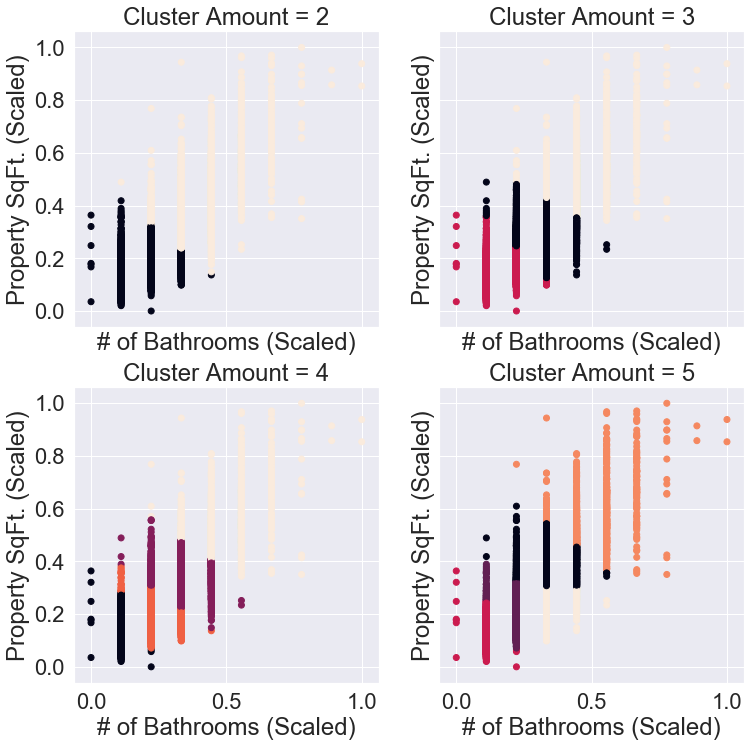

In [37]:
# creating df with the two features we want to cluster
X_c2 = train_scaled[['bathroom_count','property_sq_ft']]

# setting up subplots
fig, axs = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True)

# creating clusters, number of clusters increasing from 2 - 5
for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_c2).predict(X_c2)
    
    # plotting 
    sns.set(font_scale = 2)
    ax.scatter(X_c2.bathroom_count, X_c2.property_sq_ft, c=clusters)
    ax.set(title='Cluster Amount = {}'.format(k), ylabel='Property SqFt. (Scaled)', xlabel='# of Bathrooms (Scaled)')

- Once again, we're primarily looking for good separation between clusters
    - As before, we're seeing good separation between all cluster counts
        - We'll stick with our strategy of taking 3 clusters to make things simpler while also having more than the minimum number of clusters to work with

- Property square feet seems to be having a strong influence on our clusters since it was in both feature sets and we're seeing similar splits

#### Now we'll create our 3 cluster types and add them to our dataframe

In [38]:
# making copy of train so we don't alter the original
train_k2 = train_scaled.copy()

# creating kmeans object and fitting to data
kmeans_2 = KMeans(n_clusters=3)
kmeans_2.fit(X_c2)

# creating clusters and adding as column
train_k2['cluster'] = kmeans_2.predict(X_c2)

#### Now we're going to examine our clusters in-depth and identify what they each represent.

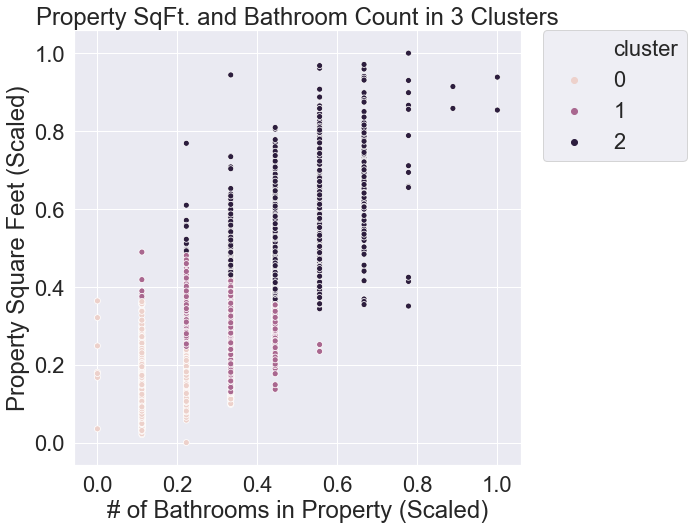

In [39]:
# setting figure and text size 
sns.set(rc = {'figure.figsize':(8,8)})
sns.set(font_scale = 2)

# plotting data, setting title and scaling y axis values to simplify them
sns.scatterplot(x = train_k2['bathroom_count'], y = train_k2['property_sq_ft'], data = train_k2, hue = 'cluster').set_title("Property SqFt. and Bathroom Count in 3 Clusters")
plt.ylabel("Property Square Feet (Scaled)")
plt.xlabel("# of Bathrooms in Property (Scaled)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Cluster 0 is mostly
    - medium-to-high bathroom count
    - medium-to-large size properties


- Cluster 1 is mostly
    - low-to-medium bathroom count 
    - small size properties
    
    
- Cluster 2 is mostly 
    - low-to-medium bathroom count
    - small-to-medium size properties

## Cluster Feature Set 2 - Hypothesis Test - ANOVA

Now that we've identified the characterstics of our properties, we'll perform an anova test to see if there is any difference in their average log errors.

- H0 = There is no difference between the average log error of cluster 0, cluster 1, and cluster 2
- Ha = There is a difference between the average log error of cluster 0, cluster 1, and cluster 2

In [40]:
# creating an array for the log error of each cluster type
cluster_0 = train_k2[train_k2.cluster == 0].log_error
cluster_1 = train_k2[train_k2.cluster == 1].log_error
cluster_2 = train_k2[train_k2.cluster == 2].log_error

# performing ANOVA test
f, p = stats.f_oneway(cluster_0, cluster_1, cluster_2)

# printing results
print(f'alpha = .05\n')
print(f'f = {f:.5f}')
print (f'p = {p}')

alpha = .05

f = 4.77809
p = 0.008420494396545347


- p is less than alpha
- We reject our null hypothesis and conclude there is a difference in the average log error of the clusters
- We will use these clusters as features in our modeling phase

### CLUSTER FEATURE SET 3 - Bathroom Count | Tax_Dollar_Value 

Let's cluster using these two features and check if there is any difference between their log error values.

To begin, well use subplots to see what are clusters look like with different cluster amounts. This gives us a good idea of how many clusters we should choose for a given pair.

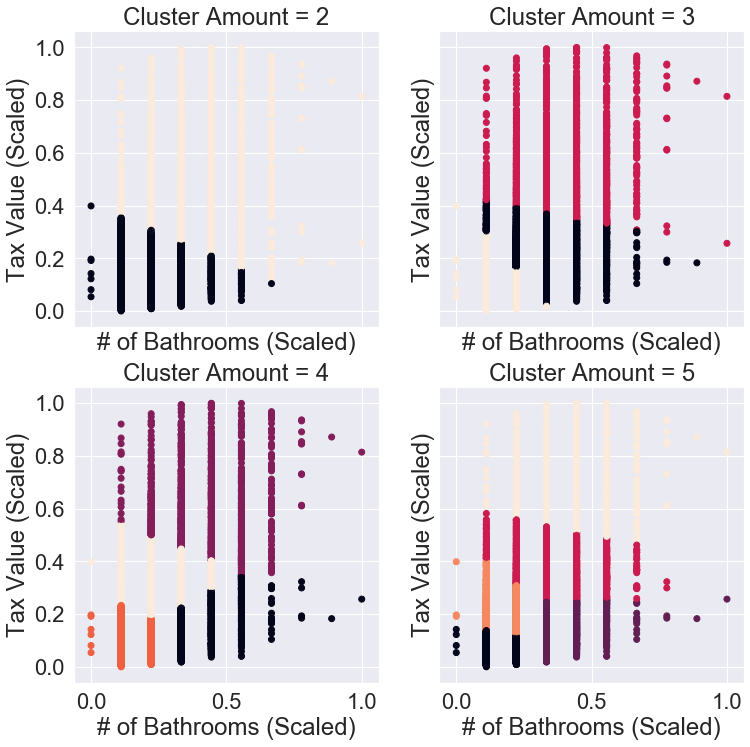

In [41]:
# creating df with the two features we want to cluster
X_c3 = train_scaled[['bathroom_count','tax_dollar_value']]

# setting up subplots
fig, axs = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True)

# creating clusters, number of clusters increasing from 2 - 5
for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_c3).predict(X_c3)
    
    # plotting 
    sns.set(font_scale = 2)
    ax.scatter(X_c3.bathroom_count, X_c3.tax_dollar_value, c=clusters)
    ax.set(title='Cluster Amount = {}'.format(k), ylabel='Tax Value (Scaled)', xlabel='# of Bathrooms (Scaled)')

- Still looking for clean separation and only cluster counts 2 and 3 depict this
    - Once again we'll opt for 3 to have an extra cluster beyond the minimum to work with

#### Now we'll create our 3 cluster types and add them to our dataframe

In [42]:
# making copy of train so we don't alter the original
train_k3 = train_scaled.copy()

# creating kmeans object and fitting to data
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(X_c3)

# creating clusters and adding as column
train_k3['cluster'] = kmeans_3.predict(X_c3)

#### Now we're going to examine our clusters in-depth and identify what they each represent.

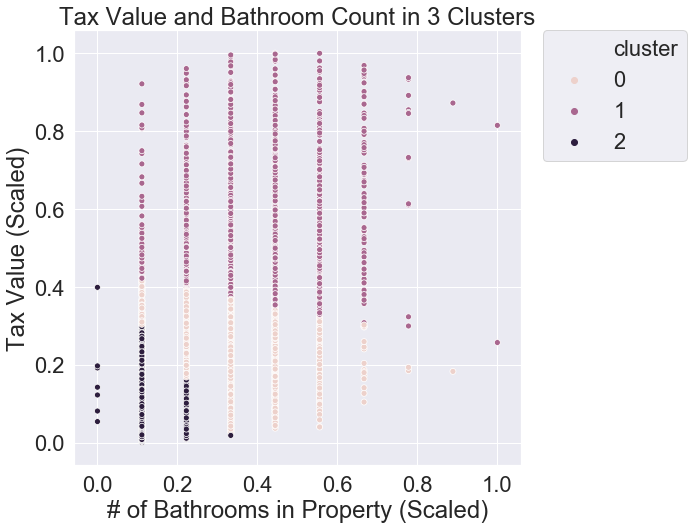

In [43]:
# setting figure and text size 
sns.set(rc = {'figure.figsize':(8,8)})
sns.set(font_scale = 2)

# plotting data, setting title and scaling y axis values to simplify them
sns.scatterplot(x = train_k3['bathroom_count'], y = train_k3['tax_dollar_value'], data = train_k3, hue = 'cluster').set_title("Tax Value and Bathroom Count in 3 Clusters")
plt.ylabel("Tax Value (Scaled)")
plt.xlabel("# of Bathrooms in Property (Scaled)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Cluster 0 is mostly
    - Low-to-medium bathroom count, low-to-medium value properties


- Cluster 1 is mostly
    - Low-to-medium bathroom count, medium-to-high value properties
    

- Cluster 2 is mostly
    - Low bathroom count, low value properties

## Cluster Feature set 3 - Hypothesis Test - ANOVA

Now that we've identified the characterstics of our properties, we'll perform an anova test to see if there is any difference in their average log errors.

- H0 = There is no difference between the average log error of cluster 0, cluster 1, and cluster 2
- Ha = There is a difference between the average log error of cluster 0, cluster 1, and cluster 2

In [44]:
# creating an array for the log error of each cluster type
cluster_0 = train_k3[train_k3.cluster == 0].log_error
cluster_1 = train_k3[train_k3.cluster == 1].log_error
cluster_2 = train_k3[train_k3.cluster == 2].log_error

# performing ANOVA test
f, p = stats.f_oneway(cluster_0, cluster_1, cluster_2)

# printing results
print(f'alpha = .05\n')
print(f'f = {f:.5f}')
print (f'p = {p}')

alpha = .05

f = 0.63356
p = 0.5307065956665906


- p is much greater than alpha

- We fail to reject our null hypothesis and conclude there is no difference in log error between the clusters

- For these reasons we will not be using this cluster for further analysis

### Exploration Takeaways

Non Clustered Exploration

- Property_Sq_ft
    - Visualization and Hypothesis test suggest that lower property_sq_ft may be drivers of log_error values above 0
        

- Tax_Dollar_Value
    - Visualization and second hypothesis test are evidence that lower tax_dollar_value may be a driver of log_error values below 0
        

- Bathroom_count
    - Visualization and hypothesis test suggest that lower bathroom_count may be a driver of log_error values above 0


- Log errors above 0 aren't good since they signal overestimation of property values
- Log errors below 0 aren't good since they signal underestimation of property values


- Considering the average log error values in our visualizations appeared to be at or very close to 0, we want log error values that are line with the average, not too far above or below

Clustered Exploration


- Created unique feature sets, each was composed of a different pair of our features above
    - Created clusters from each set and set the number of clusters within each to 3
        - Feature set 1: property_sq_ft | tax_dollar_value
        - Feature set 2: property_sq_ft | bathroom_count
        - Feature set 3: bathroom_count | tax_dollar_value


- Ran ANOVA tests on each pair's clusters to determine if there were any differences in log error
    - Only the clusters created using property_sq_ft and bathroom_count showed differences in log error
        - If log errors meaningfully fluctuate between these cluster types, they may be useful as features in our model to predict log error 


Moving Forward


- With all this being noted, we will move into modeling with the following as prospective features
    - tax_dollar_value
    - property_sq_ft
    - bathroom_count
    - Feature set 2's clusters

## Modeling
We'll now construct several models that will attempt to predict the log error associated with each property. 

### Baseline Model
Our first model is a baseline model that will always predict the population average log error. 

It will also serve as the benchmark that our alternate models will seek to outperform.

In [49]:
# creating empty dataframe
y_train = pd.DataFrame()

# adding log_error column to empty df
y_train['log_error'] = train['log_error']

# make baseline prediction equal to logerror mean
y_train['baseline_pred'] = y_train['log_error'].mean()

# evaluate rmse and print results
rmse_train_bl = mean_squared_error(y_train.log_error, y_train.baseline_pred)**(1/2)
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_bl)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1545438954603233


- Baseline RMSE is .15454389 and the metric our other models need to improve upon

### TRAIN
Our models will be fitted to the train dataset and then predict its logerror values.

### Model 1 (All Feature Model)
Overview: Let's create a model that uses all of the features from our exploration phase including clusters.

Model Features 
- property_sq_ft
- tax_dollar_value
- bathroom_count
- clusters
    - Features: property_sq_ft and bathroom_count
    - Number of clusters: 3

In [94]:
def model_1(train, predict):
    """
    Accepts 2 dataframes. 
    Train is the train df that model 1 will fit to. 
    Predict is the df you would like model 1 to predict the log_error of after fitting to train.
    Returns RMSE of log_error predictions vs actual log_error.
    """
    # making copy of train so we don't alter the original
    cluster_df = predict.copy()
    
    # creating df with the two features we want to cluster
    X = cluster_df[['bathroom_count','property_sq_ft']]

    # creating kmeans object and fitting to data
    kmeans = KMeans(n_clusters = 3)
    kmeans.fit(X)

    # creating clusters and adding as column
    cluster_df['cluster'] = kmeans.predict(X)
    
    # creating dummy df using cluster column
    dummy_df = pd.get_dummies(cluster_df['cluster'])
    
    # renaming dummy columns 
    dummy_df.rename(columns = {0: 'cluster_0', 1: 'cluster_1', 2: 'cluster_2'}, inplace=True)
    
    # adding dummy df to original df
    cluster_df = pd.concat([cluster_df, dummy_df], axis = 1)
    
    # dropping column dummy data is based on
    cluster_df.drop(columns=['cluster'] , inplace = True)
    
    # select features for model 1 predictions
    Xfeat = cluster_df[['bathroom_count', 'property_sq_ft', 'tax_dollar_value', 'cluster_0', 'cluster_1', 'cluster_2']]
    yfeat = pd.DataFrame(cluster_df['log_error'])

    # creating linear regression object
    lm = LinearRegression(normalize=True)

    # fitting model to train data
    lm.fit(train[['bathroom_count', 'property_sq_ft', 'tax_dollar_value', 'cluster_0', 'cluster_1', 'cluster_2']], train['log_error'])

    # predict logerror with model 1
    yfeat['model_1_pred'] = lm.predict(Xfeat)

    # evaluate RMSE and print results
    rmse_m1 = mean_squared_error(yfeat.log_error, yfeat.model_1_pred)**(1/2)
    print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_m1)

In [95]:
cluster_dummy(train_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.15437753154968492


- RMSE value is below baseline's so we'll be using this model in validation

#### model 2 - no clusters

In [96]:
def model_2(train, predict):
    """
    Accepts 2 dataframes. 
    Train is the train df that model 2 will fit to. 
    Predict is the df you would like model 2 to predict the log_error of after fitting to train.
    Returns RMSE of log_error predictions vs actual log_error.
    """
    # making copy of train so we don't alter the original
    predict_df = predict.copy()

    # select features for model 2 predictions
    Xfeat = predict_df[['bathroom_count', 'property_sq_ft', 'tax_dollar_value']]
    yfeat = pd.DataFrame(predict_df['log_error'])

    # creating linear regression object
    lm = LinearRegression(normalize=True)

    # fitting model to train data
    lm.fit(train[['bathroom_count', 'property_sq_ft', 'tax_dollar_value']], train['log_error'])

    # predict logerror with model 2
    yfeat['model_2_pred'] = lm.predict(Xfeat)

    # evaluate RMSE and print results
    rmse_m2 = mean_squared_error(yfeat.log_error, yfeat.model_2_pred)**(1/2)
    print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_m2)

In [97]:
model_2_train(train_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1543829234201506


#### model 3 - only clusters

In [98]:
def model_3(train, predict):
    """
    Accepts 2 dataframes. 
    Train is the train df that model 3 will fit to. 
    Predict is the df you would like model 3 to predict the log_error of after fitting to train.
    Returns RMSE of log_error predictions vs actual log_error.
    """
    # making copy of train so we don't alter the original
    cluster_df = predict.copy()
    
    # creating df with the two features we want to cluster
    X = cluster_df[['bathroom_count','property_sq_ft']]

    # creating kmeans object and fitting to data
    kmeans = KMeans(n_clusters = 3)
    kmeans.fit(X)

    # creating clusters and adding as column
    cluster_df['cluster'] = kmeans.predict(X)
    
    # creating dummy df using cluster column
    dummy_df = pd.get_dummies(cluster_df['cluster'])
    
    # renaming dummy columns 
    dummy_df.rename(columns = {0: 'cluster_0', 1: 'cluster_1', 2: 'cluster_2'}, inplace=True)
    
    # adding dummy df to original df
    cluster_df = pd.concat([cluster_df, dummy_df], axis = 1)
    
    # dropping column dummy data is based on
    cluster_df.drop(columns=['cluster'] , inplace = True)
    
    # select features for model 3 predictions
    Xfeat = cluster_df[['cluster_0', 'cluster_1', 'cluster_2']]
    yfeat = pd.DataFrame(cluster_df['log_error'])

    # creating linear regression object
    lm = LinearRegression(normalize=True)

    # fitting model to train data
    lm.fit(train[['cluster_0', 'cluster_1', 'cluster_2']], train['log_error'])

    # predict logerror with model 3
    yfeat['model_3_pred'] = lm.predict(Xfeat)

    # evaluate RMSE and print results
    rmse_m3 = mean_squared_error(yfeat.log_error, yfeat.model_3_pred)**(1/2)
    print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_m3)

In [99]:
model_3_train(train_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.15450770480063816


#### model 1 validate

In [48]:
y_validate = pd.DataFrame()

X_validate = validate[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'heating_system_type_2', 'heating_system_type_7', 'heating_system_type_20']]
y_validate ['logerror'] = validate['logerror']

KeyError: "None of [Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',\n       'taxvaluedollarcnt', 'heating_system_type_2', 'heating_system_type_7',\n       'heating_system_type_20'],\n      dtype='object')] are in the [columns]"

In [ ]:
# predict validate
y_validate['model_1_pred'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.model_1_pred)**(1/2)

print("RMSE for OLS using LinearRegression\nvalidateing/In-Sample: ", rmse_validate)

#### model 1 test

In [ ]:
y_test = pd.DataFrame()

X_test = test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'heating_system_type_2', 'heating_system_type_7', 'heating_system_type_20']]
y_test ['logerror'] = test['logerror']

# predict test
y_test['model_1_pred'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.model_1_pred)**(1/2)

print("RMSE for OLS using LinearRegression\ntesting/In-Sample: ", rmse_test)

#### model 2 and 3

In [ ]:
X_train2 = train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'heating_system_type_2', 'heating_system_type_7', 'heating_system_type_20']]

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train2, y_train.logerror)

# predict train
y_train['model_2_pred'] = lm2.predict(X_train2)

# evaluate: rmse
rmse_train2 = mean_squared_error(y_train.logerror, y_train.model_2_pred)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train2)


In [ ]:
X_train3 = train[['bathroomcnt', 'bedroomcnt','calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]

# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train3, y_train.logerror)

# predict train
y_train['model_3_pred'] = lm3.predict(X_train3)

# evaluate: rmse
rmse_train3 = mean_squared_error(y_train.logerror, y_train.model_3_pred)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train3)

#### lasso 

In [ ]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.logerror)

# predict train
y_train['lassopred'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.lassopred)**(1/2)


print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train)

#### validate

In [ ]:
y_validate = pd.DataFrame()

X_validate = validate[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'heating_system_type_2', 'heating_system_type_7', 'heating_system_type_20']]
y_validate['logerror'] = validate['logerror']

In [ ]:
# predict train
y_validate['lassopred'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.lassopred)**(1/2)


print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_validate)

#### test

In [ ]:
y_test = pd.DataFrame()

X_test = test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'heating_system_type_2', 'heating_system_type_7', 'heating_system_type_20']]
y_test['logerror'] = test['logerror']

In [ ]:
# predict train
y_test['lassopred'] = lars.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.lassopred)**(1/2)


print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_test)

## Overall Conclusion and Takeaways

In [ ]:
test.head()

In [ ]:
validate.shape

In [ ]:
test.shape

In [ ]:
train_scaled.shape

In [ ]:
train.head()

In [ ]:
train, validate, test, train_scaled, validate_scaled, test_scaled = final_prep()

In [ ]:
train_scaled.head()